# Introduction 

This Jupyter notebook was used to produce all of the plots in Boone (2019) showing the performance
of the avocado classifier on the PLAsTiCC dataset. To rerun this notebook, first follow the [steps on
avocado's readthedocs page](https://avocado-classifier.readthedocs.io/en/latest/plasticc.html) to
generate the datasets, produce the classifiers, and output the predictions that are analyzed in this
notebook. To run this notebook, copy it into your avocado working directory and run it using Jupyter.

This notebook has the same dependencies as avocado itself along with obviously requiring Jupyter to
be installed. Optionally, the [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/) package can
be installed to produce some interactive plots with widgets, although these can also all be viewed
non-interactively.

Note that the augmentation procedure in avocado is not deterministic, so the results will vary slightly
with every run. Most of the plots should not change very much, but plots that display specific light
curves from the augmented training set will be of completely different objects when run on a new
augmented training set.

# Configuration

In [1]:
# Choose which dataset to use.
dataset_name = 'plasticc_test'

In [2]:
# Use inline plots for github. Install ipywidgets, and change this to ipympl
# if you want to have interactive plots.
%matplotlib inline
# %matplotlib ipympl

In [3]:
# Default settings for matplotlib figures
import matplotlib as mpl

# Choose how big to make figures. This will scale the text size.
mpl.rcParams['figure.figsize'] = (5, 4)

# Set the DPI. This will change how big things appear in Jupyter lab
mpl.rcParams['figure.dpi'] = 120

In [4]:
# Choose which predictions to load. Note that each set of predictions takes a couple GB of RAM
# to load, so it isn't recommended to load everything at the same time. Simply comment out the
# predictions that you do not want to load.

# Predictions generated by avocado to use in the analysis.
avocado_predictions = {
    'flat_weight': 'Flat-weighted classifier',
    'redshift_weight': 'Redshift-weighted classifier',

    'flat_weight_bias_low': 'Flat-weighted, low-z bias',
    'flat_weight_bias_high': 'Flat-weighted, high-z bias',

    'redshift_weight_bias_low': 'Redshift-weighted, low-z bias',
    'redshift_weight_bias_high': 'Redshift-weighted, high-z bias',
}

# Predictions generated externally to use in the analysis.
# These were downloaded from the following thread on Kaggle:
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/75179
external_predictions = {
    # 'kaggle_kyle':  ('Kaggle - Kyle Boone', '../unblind/submissions/submission_1_kyle.csv'),
    # 'kaggle_mike_silogram': ('Kaggle - Mike & Silogram', '../unblind/submissions/submission_2_silogram.csv'),
    # 'kaggle_major_tom': ('Kaggle - Major Tom', '../unblind/submissions/submission_3_mamas.csv'),
    # 'kaggle_ahmet_erdem': ('Kaggle - AhmetErdem', '../unblind/submissions/submission_4_ahmet.csv'),
    # 'kaggle_skz' : ('Kaggle - SKZ', '../unblind/submissions/submission_5_cpmp.csv'),
}

In [5]:
# Labels for plots

plot_labels = {
    6: 'Single micro-lens - 6',
    15: 'TDE - 15',
    16: 'Eclipsing Binary - 16',
    42: 'SNII - 42',
    52: 'SNIax - 52',
    53: 'Mira - 53',
    62: 'SNIbc - 62',
    64: 'Kilonova - 64',
    65: 'M-dwarf - 65',
    67: 'SNIa-91bg - 67',
    88: 'AGN - 88',
    90: 'SNIa - 90',
    92: 'RR lyrae - 92',
    95: 'SLSN-I - 95',
    99: 'Unknown - 99',
}

plot_labels_short = {
    6: 'Single $\mu$-lens - 6',
    15: 'TDE - 15',
    16: 'Eclip. Binary - 16',
    42: 'SNII - 42',
    52: 'SNIax - 52',
    53: 'Mira - 53',
    62: 'SNIbc - 62',
    64: 'Kilonova - 64',
    65: 'M-dwarf - 65',
    67: 'SNIa-91bg - 67',
    88: 'AGN - 88',
    90: 'SNIa - 90',
    92: 'RR lyrae - 92',
    95: 'SLSN-I - 95',
    99: 'Unknown - 99',
}

plot_labels_extra_short = {
    6: 'Single $\mu$-lens',
    15: 'TDE',
    16: 'Eclip. Binary',
    42: 'SNII',
    52: 'SNIax',
    53: 'Mira',
    62: 'SNIbc',
    64: 'Kilonova',
    65: 'M-dwarf',
    67: 'SNIa-91bg',
    88: 'AGN',
    90: 'SNIa',
    92: 'RR lyrae',
    95: 'SLSN-I',
    99: 'Unknown',
}

# Python setup and utility funcitons

In [6]:
import avocado
import itertools
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from scipy.stats import binned_statistic

def plot_binned_mean(x, y, num_bins, **kwargs):
    means, bin_edges, binnumber = binned_statistic(x, y, bins=num_bins)
    
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
    
    plt.plot(bin_centers, means, **kwargs)
    
os.makedirs('./figures', exist_ok=True)

# Load data

## Load the dataset

In [7]:
print("Loading dataset...")
dataset = avocado.load(dataset_name, metadata_only=True)

# In the PLAsTiCC test data, the class 99 objects are split out. Combine them back together.
dataset.metadata['raw_class'] = dataset.metadata['class']
dataset.metadata['class'] = np.clip(dataset.metadata['class'], None, 99)

# Setup the prediction arrays
predictions = []
kaggle_predictions = []
prediction_names = []
prediction_labels = []

print("Done!")

Loading dataset...
Done!


## Load avocado-generated predictions

In [8]:
print("Loading predictions...")

for prediction_name, prediction_label in avocado_predictions.items():
    print("    Loading %s..." % prediction_label)
    prediction = dataset.load_predictions(prediction_name)
    predictions.append(prediction)
    kaggle_predictions.append(avocado.plasticc.create_kaggle_predictions(dataset, prediction))
    prediction_names.append(prediction_name)
    prediction_labels.append(prediction_label)
    
print("Done!")

Loading predictions...
    Loading Flat-weighted classifier...
    Loading Redshift-weighted classifier...
    Loading Flat-weighted, low-z bias...
    Loading Flat-weighted, high-z bias...
    Loading Redshift-weighted, low-z bias...
    Loading Redshift-weighted, high-z bias...
Done!


## Load external predictions

In [9]:
def load_csv_prediction(path):
    # Read the prediction and convert it to our format.
    kaggle_prediction = pd.read_csv(path)
    kaggle_prediction.set_index('object_id', drop=True, inplace=True)
    kaggle_prediction.sort_index(inplace=True)
    
    kaggle_prediction.index = dataset.metadata.index
    kaggle_prediction.columns = [int(i.split('_')[1]) for i in kaggle_prediction.columns]
    kaggle_prediction = kaggle_prediction.reindex(sorted(kaggle_prediction.columns), axis=1)

    # Create a version of the prediction without class 99 predictions.
    prediction = kaggle_prediction.drop(99, axis=1)
    norm = np.sum(prediction, axis=1)
    prediction = prediction.div(norm, axis=0)
    
    return prediction, kaggle_prediction

In [10]:
print("Loading external predictions...")

for prediction_name, (prediction_label, path) in external_predictions.items():
    print("    Loading %s..." % prediction_label)
    prediction, kaggle_prediction = load_csv_prediction(path)

    predictions.append(prediction)
    kaggle_predictions.append(kaggle_prediction)
    prediction_names.append(prediction_name)
    prediction_labels.append(prediction_label)

Loading external predictions...


## Load the training set

In [11]:
d_train = avocado.load('plasticc_train')

# Load the features if they have been computed.
try:
    d_train.load_raw_features()
    d_train.select_features(avocado.plasticc.PlasticcFeaturizer());
except avocado.AvocadoException:
    print("Training set features not available! Some functionality will be missing!")

# Evaluate metrics

## Flat metric

In [12]:
flat_metric_scores = []

print("Flat metric:")
for prediction, prediction_label in zip(predictions, prediction_labels):
    scores = avocado.weighted_multi_logloss(
        dataset.metadata['class'],
        prediction,
        class_weights=avocado.plasticc.plasticc_flat_weights,
        return_object_contributions=True
    )
    print("%30s: %.5f" % (prediction_label, np.sum(scores)))
    flat_metric_scores.append(scores)

Flat metric:
      Flat-weighted classifier: 0.46867
  Redshift-weighted classifier: 0.51021
     Flat-weighted, low-z bias: 0.46863
    Flat-weighted, high-z bias: 0.47200
 Redshift-weighted, low-z bias: 0.50886
Redshift-weighted, high-z bias: 0.50748


## Kaggle metric

In [13]:
kaggle_metric_scores = []

print("Kaggle metric:")
for prediction, prediction_label in zip(kaggle_predictions, prediction_labels):
    scores = avocado.weighted_multi_logloss(
        dataset.metadata['class'],
        prediction,
        class_weights=avocado.plasticc.plasticc_kaggle_weights,
        return_object_contributions=True
    )
    print("%30s: %.5f" % (prediction_label, np.sum(scores)))
    kaggle_metric_scores.append(scores)

Kaggle metric:
      Flat-weighted classifier: 0.64986
  Redshift-weighted classifier: 0.70937
     Flat-weighted, low-z bias: 0.65033
    Flat-weighted, high-z bias: 0.65217
 Redshift-weighted, low-z bias: 0.70752
Redshift-weighted, high-z bias: 0.70597


## Redshift-weighted metric

In [14]:
redshift_metric_scores = []

redshift_object_weights = avocado.evaluate_weights_redshift(dataset, redshift_key='redshift')

print("Redshift-weighted metric:")
for prediction, prediction_label in zip(predictions, prediction_labels):
    scores = avocado.weighted_multi_logloss(
        dataset.metadata['class'],
        prediction,
        object_weights=redshift_object_weights,
        class_weights=avocado.plasticc.plasticc_flat_weights,
        return_object_contributions=True
    )
    print("%30s: %.5f" % (prediction_label, np.sum(scores)))
    redshift_metric_scores.append(scores)

Redshift-weighted metric:
      Flat-weighted classifier: 0.52321
  Redshift-weighted classifier: 0.50079
     Flat-weighted, low-z bias: 0.52013
    Flat-weighted, high-z bias: 0.54085
 Redshift-weighted, low-z bias: 0.49942
Redshift-weighted, high-z bias: 0.49840


## Metric contributions by class

In [15]:
# Pick which scores to use for the plot

scores = flat_metric_scores
# scores = kaggle_metric_scores
# scores = redshift_metric_scores

In [16]:
object_classes = dataset.metadata['class']
class_names = np.unique(object_classes)

metric_contributions = np.zeros((len(predictions), len(class_names)))

for class_idx, class_name in enumerate(class_names):
    class_mask = object_classes == class_name
    for prediction_idx, score in enumerate(scores):
        class_contribution = np.sum(score[class_mask])
        metric_contributions[prediction_idx, class_idx] = class_contribution

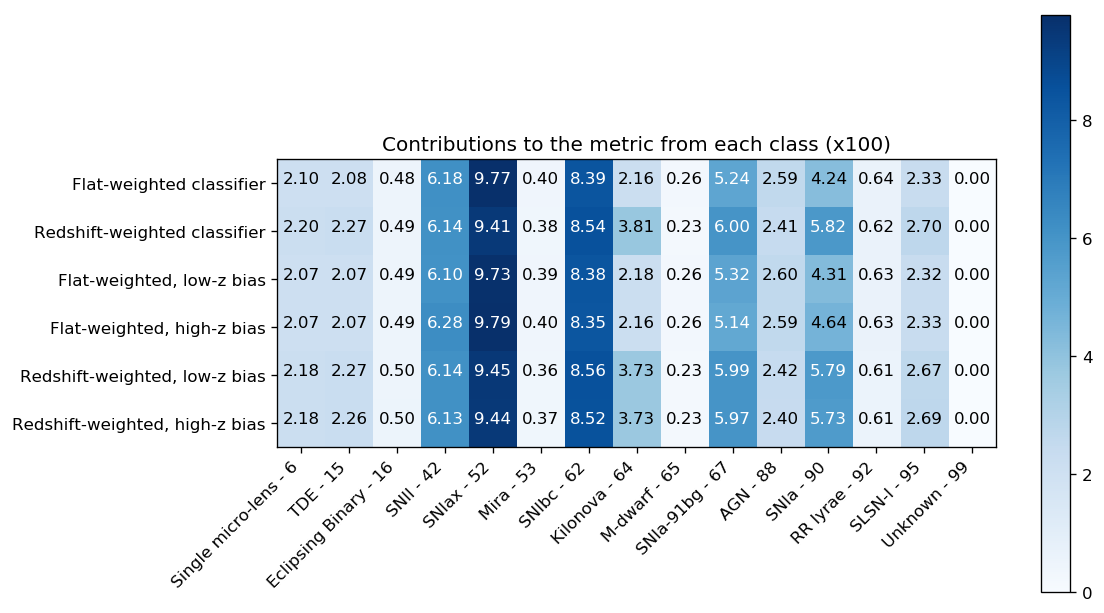

In [17]:
scale_mc = 100 * metric_contributions

plt.figure(figsize=(10, 5.5))
plt.imshow(scale_mc, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Contributions to the metric from each class (x100)')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, plot_labels.values(), rotation=45, ha='right')

yticks = prediction_labels
plt.yticks(np.arange(len(yticks)), yticks)

fmt = '.2f'
thresh = scale_mc.max() / 2.
for i, j in itertools.product(range(scale_mc.shape[0]), range(scale_mc.shape[1])):
    plt.text(j, i, format(scale_mc[i, j], fmt),
             horizontalalignment="center",
             color="white" if scale_mc[i, j] > thresh else "black")
    
plt.tight_layout()

# Confusion matrix

In [18]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=60, ha='right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.tight_layout()
    
    # Make a colorbar that is lined up with the plot
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad=0.25)
    plt.colorbar(im, cax=cax, label='Fraction of objects')


def do_confusion_matrix(index, show_title=True):
    # Plot non-normalized confusion matrix
    plt.figure(figsize=(9,8))
    
    # Only include classes that we have predictions for
    true_classes = dataset.metadata['class']
    pred = predictions[index]
    
    mask = true_classes.isin(pred.columns)
    
    mask_classes = true_classes[mask]
    mask_pred = pred[mask]

    true_indices = np.argmax(pd.get_dummies(mask_classes).values, axis=1)
    pred_indices = np.argmax(mask_pred.values, axis=-1)
    
    if show_title:
        title = 'Confusion matrix - %s' % prediction_labels[index]
    else:
        title = ''
        
    cnf_matrix = confusion_matrix(true_indices, pred_indices)
    plot_confusion_matrix(
        cnf_matrix,
        classes=[plot_labels_short[i] for i in pred.columns],
        normalize=True,
        title=title,
    )


Normalized confusion matrix


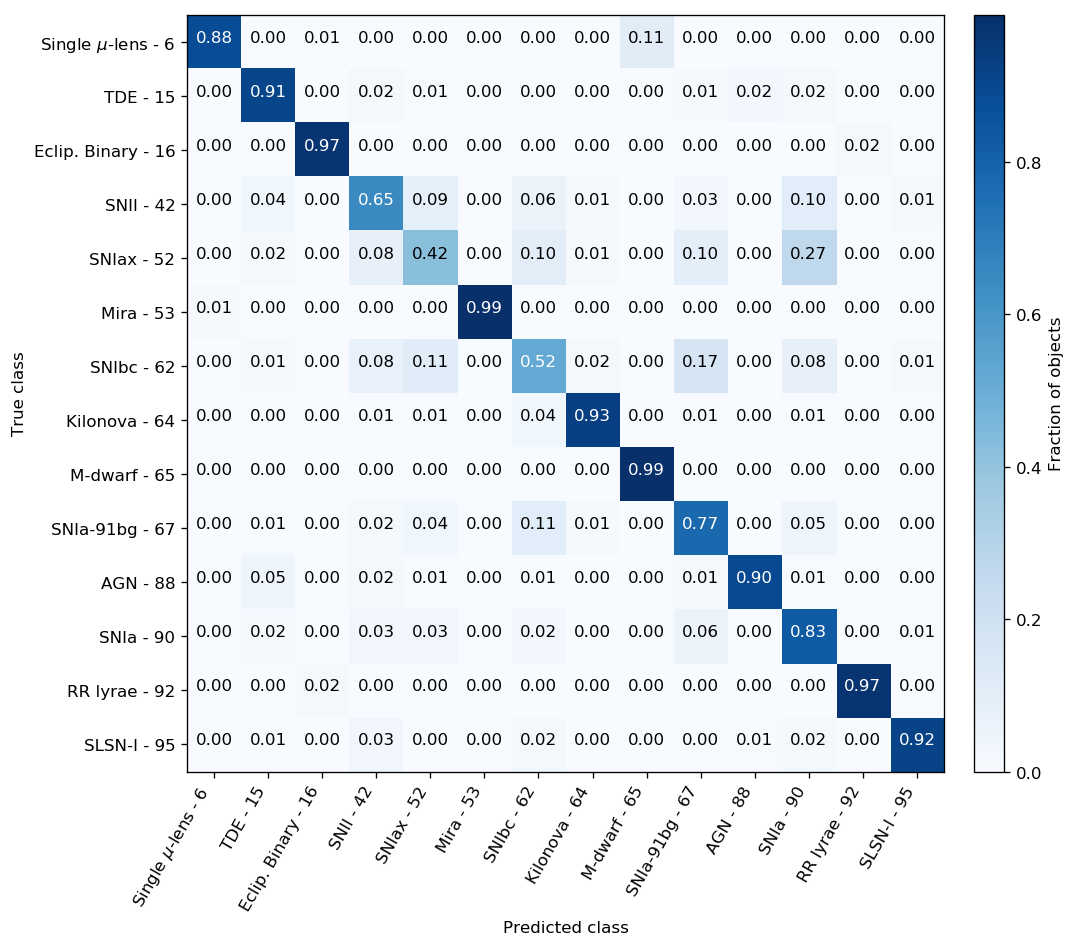

In [19]:
# Save the confusion matrix
selected_classifier = 'flat_weight'

index = prediction_names.index(selected_classifier)
do_confusion_matrix(index, show_title=False)

plt.savefig('./figures/confusion_matrix.pdf')

In [20]:
# Interactive display of the confusion matrices if ipywidgets is available.
try:
    from ipywidgets import interact, Dropdown
    index_map = {j:i for i, j in enumerate(prediction_labels)}
    interact(do_confusion_matrix, index=index_map)
except ImportError:
    print("No ipywidgets found, skipping interactive confusion matrix.")

interactive(children=(Dropdown(description='index', options={'Flat-weighted classifier': 0, 'Redshift-weighted…

# Class fractions vs redshift

In [21]:
def plot_class_fractions(plot_dataset):
    hist_classes = [64, 67, 52, 62, 90, 42, 15, 95, 88]
    hist_redshifts = np.logspace(np.log10(0.05), np.log10(3), 100)
    log_hist_redshifts = np.log10(hist_redshifts)

    colors=['C7', 'C3', 'C8', 'C0', 'C1', 'C2', 'C5', 'C6', 'C4']

    redshifts = plot_dataset.metadata['redshift']
    object_classes = plot_dataset.metadata['class']

    class_counts = np.zeros((len(hist_classes), len(hist_redshifts) - 1))
    for i in range(len(hist_classes)):
        class_counts[i] = np.histogram(redshifts[object_classes == hist_classes[i]], bins=hist_redshifts)[0]

    class_counts = class_counts / (0.0001 + np.sum(class_counts, axis=0))

    plt.figure()
    for i in range(len(hist_classes)):
        # Note: add a bit of extra width to the bars to avoid having white bars on the PDF
        plt.bar(
            (log_hist_redshifts[1:] + log_hist_redshifts[:-1]) / 2.,
            class_counts[i],
            width=1.1 * (log_hist_redshifts[1] - log_hist_redshifts[0]),
            label=plot_labels_extra_short[hist_classes[i]],
            bottom=np.sum(class_counts[:i], axis=0),
            color=colors[i]
        )

    plt.legend(loc=2, framealpha=0.7)

    plt.xlabel('Redshift')
    plt.ylabel('Fractional composition')
    plt.xlim(log_hist_redshifts[0], log_hist_redshifts[-2])
    plt.ylim(0, 1)

    xticks = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2]
    xtick_labels = ['', '', '', '', '', 0.1, '', '', '', '', '', '', '', '', 1, '']
    plt.xticks(np.log10(xticks), xtick_labels)
    plt.tight_layout()

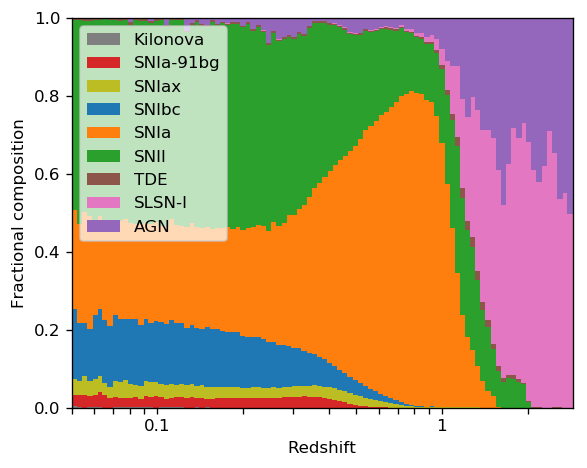

In [22]:
# Test dataset
plot_class_fractions(dataset)
plt.savefig('./figures/redshift_fractions.pdf')

Loading augmented dataset...


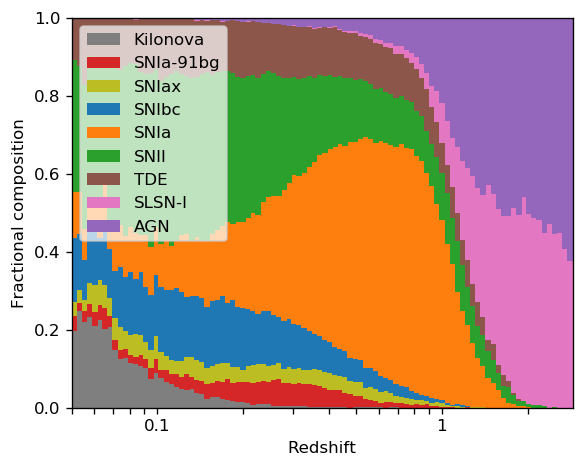

In [23]:
# Augmented dataset if available

try:
    print("Loading augmented dataset...")
    d_aug = avocado.load('plasticc_augment', metadata_only=True)

    plot_class_fractions(d_aug)
except avocado.AvocadoException:
    print("Augmented dataset not available, skipping.")

# ROC and precision-recall curves

## Utility functions for ROC and precision-recall curves

In [24]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import functools

In [25]:
def get_scores(prediction_index, target_class, reference_classes=None):
    """Retrieve the scores and class memberships given sets of target classes and reference classes
    
    Parameters
    ----------
    prediction_index : int
        The index of the prediction to use to calculate the scores.
    target_class : list
        The target class name, or a list of target class names.
    reference_classes : list (optional)
        A list of the reference class names. The reference classes must include the target classes.
        By default, all predictions are used which should sum to 1.
    
    Returns
    -------
    true_members : pandas.Series
        a Series indicating membership in the target classes. This will be True if the object is
        a member of those classes and False otherwise.
    scores : pandas.Series
        The scores for the target classes normalized to the reference class scores.
    """
    prediction = predictions[prediction_index]
    use_metadata = dataset.metadata
    
    # Check if we were passed a single class. We can do this by seeing if the
    # target class is hashable or not. Strings, floats, ints, etc. will be hashable
    # but lists, numpy arrays, etc. will not.
    try:
        hash(target_class)
        target_classes = [target_class]
    except TypeError:
        target_classes = target_class
    
    if reference_classes is not None:
        for class_name in target_classes:
            if class_name not in reference_classes:
                raise Exception("Class %s not in reference classes!" % class_name)

        mask = dataset.metadata['class'].isin(reference_classes)
        
        use_metadata = use_metadata[mask]
        prediction = prediction[mask]

        reference_scores = np.sum(prediction[reference_classes].values, axis=1)
    else:
        reference_scores = 1

    true_members = use_metadata['class'].isin(target_classes)

    target_scores = np.sum(prediction[target_classes].values, axis=1)

    scores = target_scores / reference_scores
    scores = pd.Series(scores, index=true_members.index)

    return true_members, scores

## Plot ROC curves

In [26]:
# Plot configuration

# -------------------------------------
# Pick a subset of classifiers to plot.
# -------------------------------------

# All
# selected_classifiers = None

# Paper
selected_classifiers = ['flat_weight', 'redshift_weight']

# --------------------------------------------------------
# Pick a set of reference classes to be comparing against.
# --------------------------------------------------------

# All (no 99)
reference_classes = None

# SNPCC targets
# reference_classes = [42, 62, 90]

# Galactic classes
# reference_classes = [6, 16, 53, 65, 92]

# Extragalactic classes
# reference_classes = [15, 42, 52, 62, 64, 67, 88, 90, 95]

In [27]:
def do_roc_curve(target_class, *args, **kwargs):
    """Generate a ROC curve for a set of target ids and reference ids"""
    plt.figure()
    
    print("AUCs for %s:" % plot_labels[target_class])

    for prediction_index, label in enumerate(prediction_labels):
        if selected_classifiers is not None and prediction_names[prediction_index] not in selected_classifiers:
            # Only plot selected classifiers
            continue
            
        true_members, scores = get_scores(prediction_index, target_class, *args, **kwargs)

        fpr, tpr, thresholds = roc_curve(true_members, scores)
        plt.plot(fpr, tpr, label=label)

        print("%35s: %.5f" % (label, auc(fpr, tpr)))

    plt.legend()

In [28]:
# Interactive display of the ROC curves if ipywidgets is available.
from ipywidgets import interact, Dropdown

if reference_classes:
    available_classes = reference_classes
else:
    available_classes = predictions[0].columns
    
target_widget = Dropdown(
    options={plot_labels[i]:i for i in available_classes},
    value=90,
)
interact(do_roc_curve, target_class=target_widget)

interactive(children=(Dropdown(description='target_class', index=11, options={'Single micro-lens - 6': 6, 'TDE…

<function __main__.do_roc_curve(target_class, *args, **kwargs)>

## Print AUCs for each target

In [29]:
def print_aucs(classifier_name, *args, **kwargs):
    """Generate a ROC curve for a set of target ids and reference ids"""
    for prediction_index, iter_name in enumerate(prediction_names):
        if classifier_name == iter_name:
            break
    else:
        raise Exception("No classifier with name %s" % classifier_name)

    print("AUCs for %s:" % prediction_labels[prediction_index])

    for class_id in np.unique(dataset.metadata['class']):
        try:
            true_members, scores = get_scores(prediction_index, class_id, *args, **kwargs)
        except KeyError:
            continue
            
        fpr, tpr, thresholds = roc_curve(true_members, scores)
        print("%35s: %.5f" % (plot_labels[class_id], auc(fpr, tpr)))

In [30]:
print_aucs('flat_weight')

AUCs for Flat-weighted classifier:
              Single micro-lens - 6: 0.99962
                           TDE - 15: 0.99254
              Eclipsing Binary - 16: 0.99983
                          SNII - 42: 0.93570
                         SNIax - 52: 0.85988
                          Mira - 53: 0.99947
                         SNIbc - 62: 0.92851
                      Kilonova - 64: 0.99815
                       M-dwarf - 65: 0.99999
                     SNIa-91bg - 67: 0.96672
                           AGN - 88: 0.99772
                          SNIa - 90: 0.95721
                      RR lyrae - 92: 0.99987
                        SLSN-I - 95: 0.99442


In [31]:
print_aucs('redshift_weight')

AUCs for Redshift-weighted classifier:
              Single micro-lens - 6: 0.99966
                           TDE - 15: 0.99243
              Eclipsing Binary - 16: 0.99983
                          SNII - 42: 0.90826
                         SNIax - 52: 0.84203
                          Mira - 53: 0.99937
                         SNIbc - 62: 0.91558
                      Kilonova - 64: 0.99579
                       M-dwarf - 65: 0.99999
                     SNIa-91bg - 67: 0.96015
                           AGN - 88: 0.99706
                          SNIa - 90: 0.95204
                      RR lyrae - 92: 0.99986
                        SLSN-I - 95: 0.99257


## Plot completeness vs redshift

In [32]:
# Default plot configuration

# -------------------------------------
# Pick a subset of classifiers to plot.
# -------------------------------------

# All
# selected_classifiers = None

# Paper
selected_classifiers = ['flat_weight', 'redshift_weight']

# --------------------------------------------------------
# Pick a class for the plot
# --------------------------------------------------------

class_id = 90

# --------------------------------------------------------
# Choose the purity level.
# --------------------------------------------------------

target_purity = 0.95

# --------------------------------------------------------
# Choose DDF or WFD
# --------------------------------------------------------

ddf = False

In [33]:
def evaluate_threshold(prediction_index, target_purity, class_id):
    """Determine the threshold to cut at for a given purity."""
    true_members, scores = get_scores(prediction_index, class_id, reference_classes=None)
    
    purity, completeness, thresholds = precision_recall_curve(true_members, scores)

    loc = np.argmin(np.abs(purity - target_purity))
    
    print("%35s: threshold = %.2f, completeness = %.2f" % (prediction_labels[prediction_index], thresholds[loc], completeness[loc]))
    
    return thresholds[loc]

def plot_completeness(ddf=ddf, target_purity=target_purity, class_id=class_id, selected_classifiers=selected_classifiers, labels=None):
    """Plot the completeness as a function of redshift for a given purity."""
    # Figure out which predictions to use
    if selected_classifiers is None:
        prediction_indices = np.arange(len(prediction_names))
    else:
        prediction_indices = [i for i, name in enumerate(prediction_names) if name in selected_classifiers]

    # Figure out the thresholds for each sample to achieve the target purity.
    use_thresholds = []
    print("Thresholds for purity = %.2f for %s" % (target_purity, plot_labels[class_id]))
    for prediction_index in prediction_indices:
        threshold = evaluate_threshold(prediction_index, target_purity, class_id)
        use_thresholds.append(threshold)

    class_cut = dataset.metadata['class'] == class_id
    ddf_cut = dataset.metadata['ddf']

    if ddf:
        cut = class_cut & ddf_cut
        title = 'DDF survey'
    else:
        cut = class_cut & ~ddf_cut
        title = 'WFD survey'

    cut_metadata = dataset.metadata[cut]

    plt.figure()
    plt.title(title)

    for plot_index, prediction_index in enumerate(prediction_indices):
        prediction = predictions[prediction_index]
        cut_prediction = prediction[cut]

        correct = cut_prediction[class_id] > use_thresholds[plot_index]
        
        if labels is None:
            label = prediction_labels[prediction_index]
        else:
            label = labels[plot_index]

        plot_binned_mean(
            cut_metadata['redshift'], correct, 20, label=label,
        )

    plt.legend(loc=3)
    plt.ylim(0, 1)
    plt.xlabel('Redshift')
    plt.ylabel('Completeness')
    plt.tight_layout()

Thresholds for purity = 0.95 for SNIa - 90
           Flat-weighted classifier: threshold = 0.56, completeness = 0.69
       Redshift-weighted classifier: threshold = 0.41, completeness = 0.67


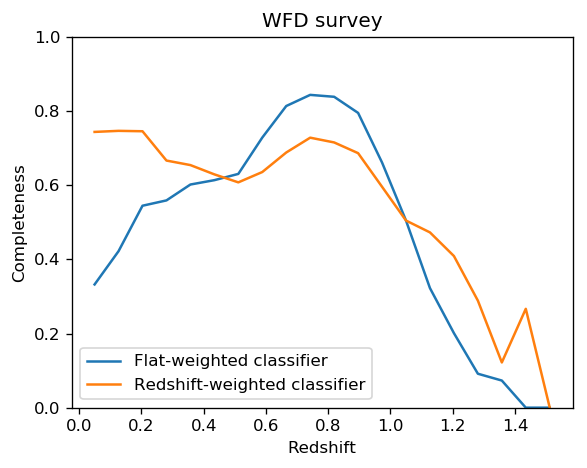

In [34]:
plot_completeness(ddf=False)
plt.savefig('./figures/completeness_wfd.eps')

Thresholds for purity = 0.95 for SNIa - 90
           Flat-weighted classifier: threshold = 0.56, completeness = 0.69
       Redshift-weighted classifier: threshold = 0.41, completeness = 0.67


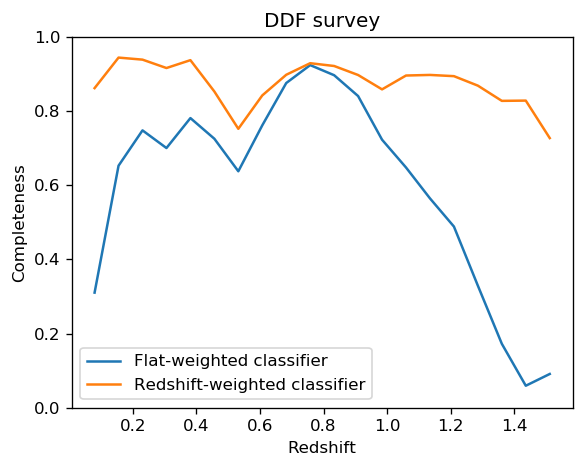

In [35]:
plot_completeness(ddf=True)
plt.savefig('./figures/completeness_ddf.eps')

Thresholds for purity = 0.95 for SNIa - 90
           Flat-weighted classifier: threshold = 0.56, completeness = 0.69
          Flat-weighted, low-z bias: threshold = 0.52, completeness = 0.71
         Flat-weighted, high-z bias: threshold = 0.62, completeness = 0.64


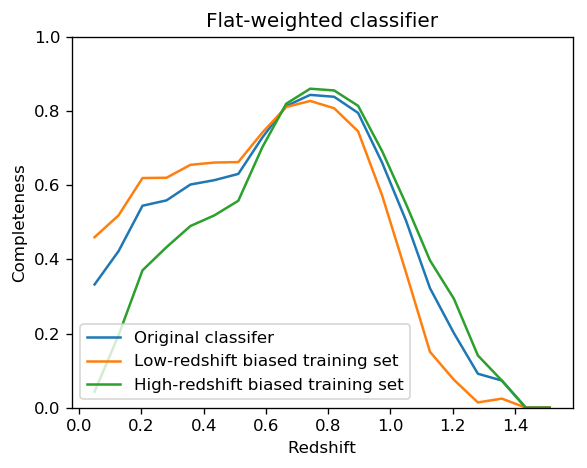

In [36]:
plot_completeness(
    ddf=False,
    selected_classifiers=['flat_weight', 'flat_weight_bias_low', 'flat_weight_bias_high'],
    labels=['Original classifer', 'Low-redshift biased training set', 'High-redshift biased training set']
)
plt.title('Flat-weighted classifier')
plt.savefig('./figures/completeness_flat_bias.eps')

Thresholds for purity = 0.95 for SNIa - 90
       Redshift-weighted classifier: threshold = 0.41, completeness = 0.67
      Redshift-weighted, low-z bias: threshold = 0.41, completeness = 0.67
     Redshift-weighted, high-z bias: threshold = 0.42, completeness = 0.67


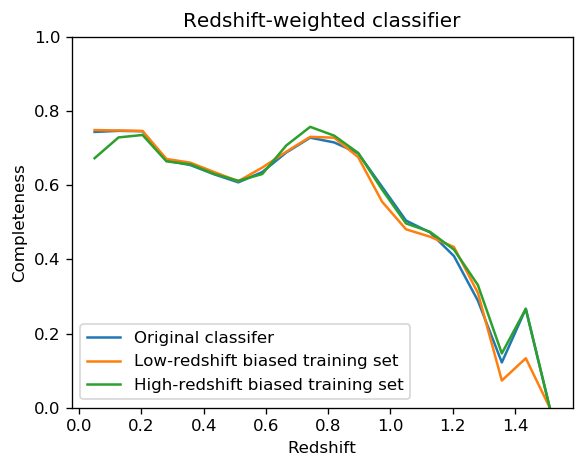

In [37]:
plot_completeness(
    ddf=False,
    selected_classifiers=['redshift_weight', 'redshift_weight_bias_low', 'redshift_weight_bias_high'],
    labels=['Original classifer', 'Low-redshift biased training set', 'High-redshift biased training set']
)
plt.title('Redshift-weighted classifier')
plt.savefig('./figures/completeness_redshift_bias.eps')

## Plot top class prediction accuracy vs redshift

In [38]:
# Default plot configuration

# -------------------------------------
# Pick a subset of classifiers to plot.
# -------------------------------------

# All
# selected_classifiers = None

# Paper
selected_classifiers = ['flat_weight', 'redshift_weight']

# --------------------------------------------------------
# Pick a class for the plot
# --------------------------------------------------------

class_id = 90

# --------------------------------------------------------
# Choose DDF or WFD
# --------------------------------------------------------

ddf = True

In [39]:
def plot_top_accuracy(ddf=ddf, class_id=class_id, selected_classifiers=selected_classifiers, labels=None):
    """Plot the accuracy of classifier as a function of redshift when looking at the top-predicted label."""
    # Figure out which predictions to use
    if selected_classifiers is None:
        prediction_indices = np.arange(len(prediction_names))
    else:
        prediction_indices = [i for i, name in enumerate(prediction_names) if name in selected_classifiers]

    class_cut = dataset.metadata['class'] == class_id
    ddf_cut = dataset.metadata['ddf']

    if ddf:
        cut = class_cut & ddf_cut
        title = 'DDF survey'
    else:
        cut = class_cut & ~ddf_cut
        title = 'WFD survey'

    cut_metadata = dataset.metadata[cut]

    plt.figure()
    plt.title(title)

    for plot_index, prediction_index in enumerate(prediction_indices):
        prediction = predictions[prediction_index]
        cut_prediction = prediction[cut]

        # Correct if predicted class has the max prediction
        correct = cut_prediction[class_id] == np.max(cut_prediction, axis=1)
        
        if labels is None:
            label = prediction_labels[prediction_index]
        else:
            label = labels[plot_index]

        plot_binned_mean(
            cut_metadata['redshift'], correct, 20, label=label,
        )

    plt.legend()
    plt.ylim(0, 1)
    plt.xlabel('Redshift')
    plt.ylabel('Top prediction accuracy')
    plt.tight_layout()

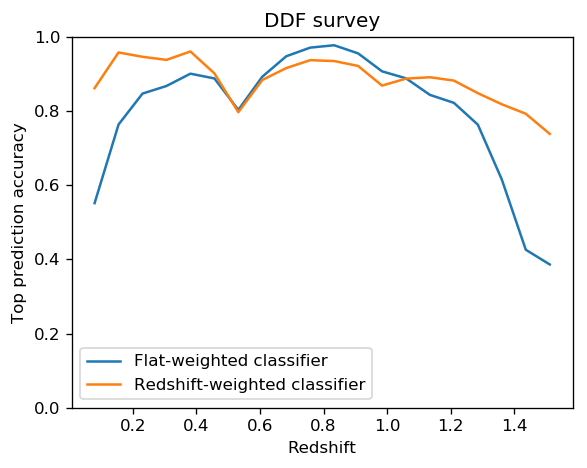

In [40]:
plot_top_accuracy()

## Prediction calibration

Text(0, 0.5, 'Fraction of correct classifications')

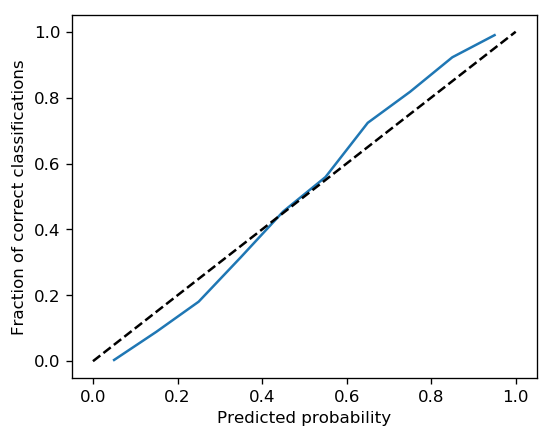

In [41]:
# Look at how well the predictions are calibrated. This ends up being relatively
# complicated to interpret because all of the classifiers were trained to optimize different
# metrics, and are therefore inherently calibrated differently.

class_name = 15
prediction_index = 1
score_bins = 10
min_redshift = 0.
max_redshift = 3.

score_bin_edges = np.linspace(0, 1, score_bins + 1)
score_bin_centers = (score_bin_edges[1:] + score_bin_edges[:-1]) / 2.

from tqdm import tqdm

scores = predictions[prediction_index][class_name]
redshifts = dataset.metadata['redshift']
true_classes = dataset.metadata['class']

redshift_cut = (
    (redshifts > min_redshift)
    & (redshifts < max_redshift)
)

cut_redshifts = redshifts[redshift_cut]
cut_scores = scores[redshift_cut]
cut_true_classes = true_classes[redshift_cut]
cut_class_counts = cut_true_classes.value_counts()

true_fractions = []

for bin_idx in range(score_bins):
    min_score = score_bin_edges[bin_idx]
    max_score = score_bin_edges[bin_idx + 1]

    bin_mask = (
        (cut_scores > min_score)
        & (cut_scores < max_score)
    )

    bin_true_classes = cut_true_classes[bin_mask]
    bin_class_counts = bin_true_classes.value_counts()

    frac_class_counts = (bin_class_counts / cut_class_counts).fillna(0)

    try:
        true_fraction = frac_class_counts[class_name] / np.sum(frac_class_counts)
    except KeyError:
        true_fraction = np.nan
        
    # print(score_bin_centers[bin_idx])
    # print(bin_class_counts.sort_values()[::-1][:3])
    # print((frac_class_counts / np.sum(frac_class_counts)).sort_values()[::-1][:3])
    # print("")
        
    true_fractions.append(true_fraction)

plt.figure()
plt.plot(score_bin_centers, true_fractions, label='Predictions')
plt.plot([0, 1], [0, 1], ls='--', c='k', label='Perfect calibration')
plt.xlabel('Predicted probability')
plt.ylabel('Fraction of correct classifications')

## Plot AUCs grouped by redshift bins

 90%|█████████ | 9/10 [00:03<00:00,  2.42it/s]/home/kboone/packages/conda/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


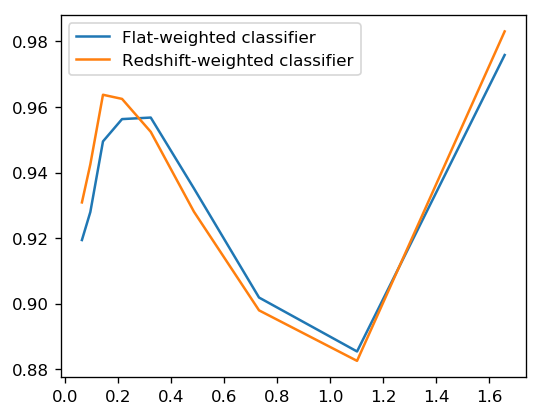

In [42]:
# Split the sample into a bunch of redshift bins, and then calculate the AUC in each of them.
#
# Note that when you do this procedure, you are effectively doing the same
# thing that we did for the redshift-weighted classifier. So we end up getting nearly
# the same plot here for both the redshift-weighted classifier and the flat-weighted classifier.

class_name = 90
num_bins = 10
selected_classifiers = ['flat_weight', 'redshift_weight']

redshift_bin_edges = np.logspace(np.log10(0.05), np.log10(3), num_bins + 1)
redshift_bin_centers = (redshift_bin_edges[1:] + redshift_bin_edges[:-1]) / 2.

redshifts = dataset.metadata['redshift']
true_classes = dataset.metadata['class']
true_members = true_classes == class_name

all_classes = np.unique(true_classes)

plt.figure()

if selected_classifiers is None:
    prediction_indices = np.arange(len(prediction_names))
else:
    prediction_indices = [i for i, name in enumerate(prediction_names) if name in selected_classifiers]


for plot_index, prediction_index in enumerate(prediction_indices):
    prediction = predictions[prediction_index]
    
    scores = prediction[class_name]

    aucs = []

    from tqdm import tqdm

    for bin_idx in tqdm(range(num_bins)):
        min_redshift = redshift_bin_edges[bin_idx]
        max_redshift = redshift_bin_edges[bin_idx + 1]

        redshift_cut = (
            (redshifts > min_redshift)
            & (redshifts < max_redshift)
        )

        cut_true_members = true_members[redshift_cut]
        cut_scores = scores[redshift_cut]

        fpr, tpr, thresholds = roc_curve(cut_true_members, cut_scores)
        bin_auc = auc(fpr, tpr)

        aucs.append(bin_auc)

    plt.plot(redshift_bin_centers, aucs, label=prediction_labels[prediction_index])
    
plt.legend()

# Lightcurve plots

## Interactive plots

In [43]:
# This requires ipywidgets to be installed
d_train.plot_interactive()

interactive(children=(IntSlider(value=0, description='index', max=7847), Dropdown(description='object_class', …

## Specific plots for the paper

In [44]:
# Note: any calls to this for the training or test sets will
# work if you rerun anything. However, augmented objects are generated
# with an element of randomness, so they won't be the same if rerunning
# all the code.
def plasticc_paper_plot(dataset, object_id, start_time=None, end_time=None,
                        min_flux=None, max_flux=None, title=None, plot_name=None, fix_scale=None):
    fig, axis = plt.subplots()
    try:
        dataset.plot_light_curve(object_id=object_id, axis=axis)
    except avocado.AvocadoError:
        print("No object found with object_id=%s! Skipping!" % object_id)
        return
    
    axis.set_xlim(start_time, end_time)
    axis.set_ylim(min_flux, max_flux)
    
    if title is not None:
        axis.set_title(title)
    
    axis.set_xlabel('MJD (days)')
    axis.legend(loc=1)
    
    if fix_scale:
        axis.ticklabel_format(axis='y', scilimits=(fix_scale, fix_scale))
    else:
        axis.ticklabel_format(axis='y', scilimits=(0,3))
    
    obj = dataset.get_object(object_id=object_id)
    
    if obj.metadata['ddf']:
        survey = 'DDF'
    else:
        survey = 'WFD'
        
    if 'reference_object_id' not in obj.metadata \
        or pd.isnull(obj.metadata['reference_object_id']):
        augment_str = ''
    else:
        augment_str = 'Augmented, '
        
    redshift = obj.metadata['redshift']
        
    axis.set_title('%s%s survey, z=%.2f' % (augment_str, survey, redshift))
    
    fig.tight_layout()
    
    fig.savefig('./figures/gp_%s.pdf' % plot_name)

### Basic GP fits

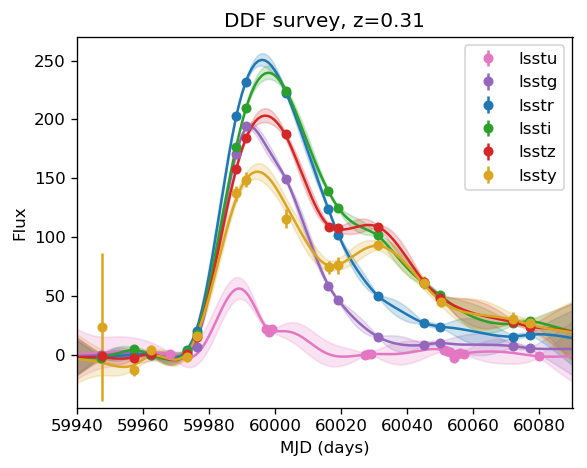

In [45]:
# GP fit to a well-sampled SN Ia light curve
plasticc_paper_plot(d_train, 'plasticc_000001920', 59940, 60090, -45, 270, plot_name='snia_highs2n')

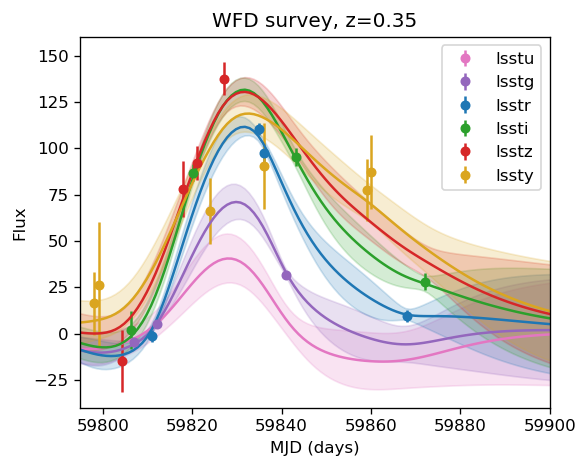

In [46]:
# GP fit to a poorly-sampled SN Ia light curve
# plasticc_paper_plot(d_train, 'plasticc_058147789', 60430, 60570, -40, 160, plot_name='snia_lows2n')
plasticc_paper_plot(d_train, 'plasticc_086637920', 59795, 59900, -40, 160, plot_name='snia_lows2n')

### GP fits with no rise time data

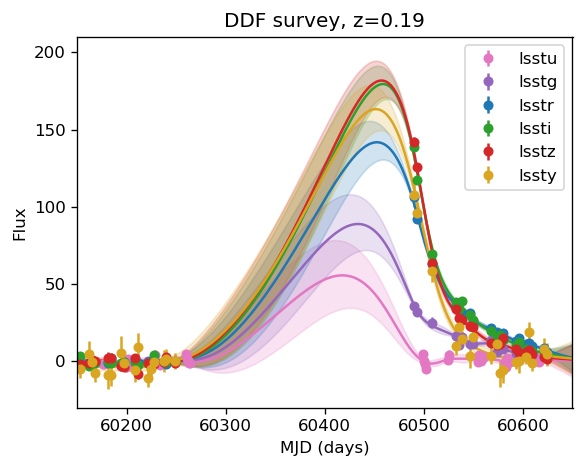

In [47]:
# GP fit with no rise time data
plasticc_paper_plot(d_train, 'plasticc_000001124', 60150, 60650, -30, 210, plot_name='snia_norise')

### Augmented lightcurve examples

In [48]:
# Load a subset of the augmented dataset
d_aug_micro = avocado.load('plasticc_augment', chunk=1, num_chunks=100)

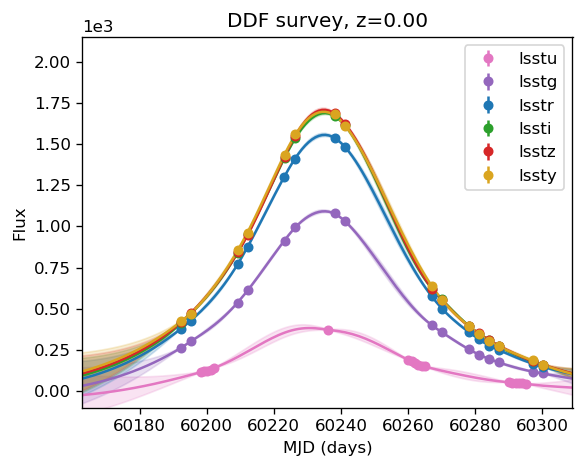

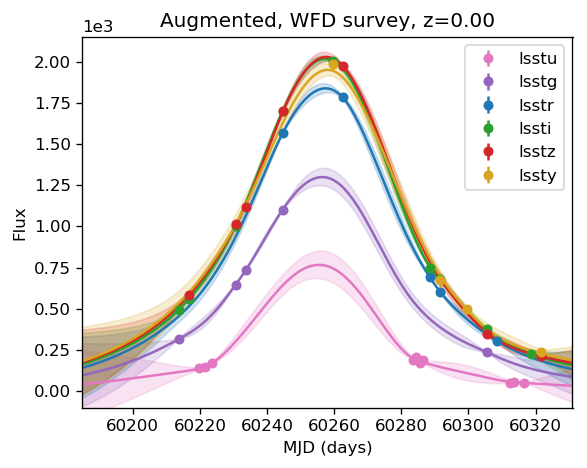

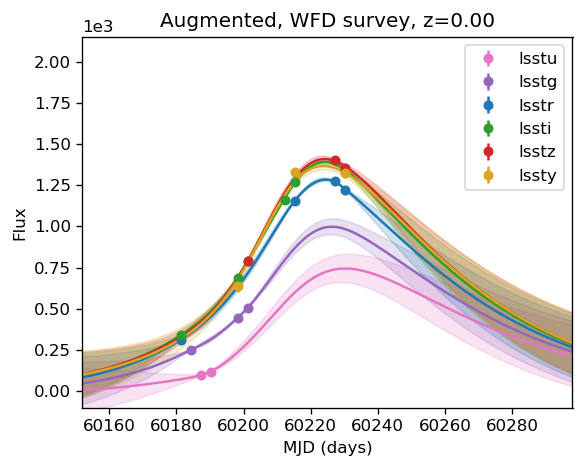

In [49]:
# Augmented fits to a single lens microlensing event.
# All of the plots are roughly referenced to an observation near maximum in r-band

start_dt = 78
end_dt = 68

ref_time = 60241
plasticc_paper_plot(
    d_aug_micro, 'plasticc_000018556',
    ref_time - start_dt, ref_time + end_dt,
    -100, 2150,
    fix_scale=0,
    plot_name='mulens_original'
)

ref_time = 60263
plasticc_paper_plot(
    d_aug_micro, 'plasticc_000018556_aug_ATrVehWlir',
    ref_time - start_dt, ref_time + end_dt,
    -100, 2150,
    fix_scale=0,
    plot_name='mulens_aug_1'
)

ref_time = 60230
plasticc_paper_plot(
    d_aug_micro, 'plasticc_000018556_aug_TiUXIzzpAV',
    ref_time - start_dt, ref_time + end_dt,
    -100, 2150,
    fix_scale=0,
    plot_name='mulens_aug_2'
)

In [50]:
# Load a subset of the augmented dataset
d_aug_mira = avocado.load('plasticc_augment', chunk=37, num_chunks=100)

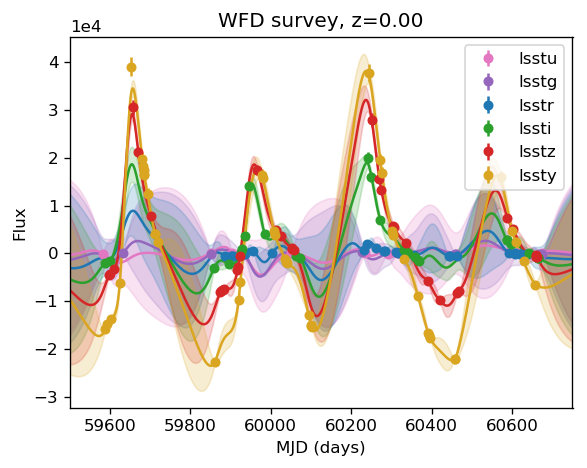

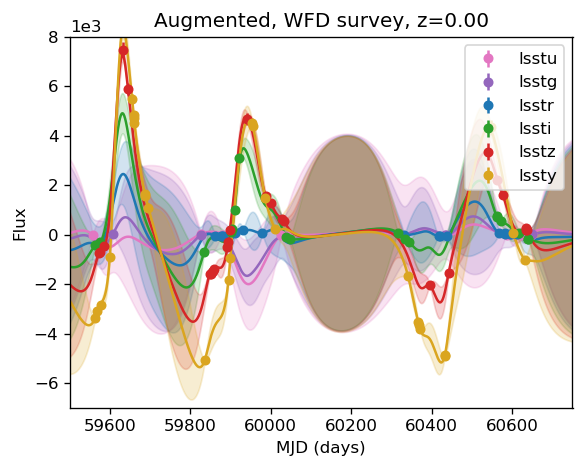

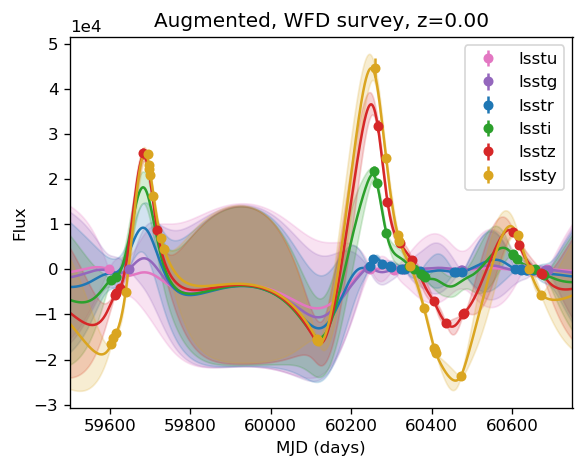

In [51]:
# Augmented fits to a Mira variable
# All of the plots are roughly referenced to an observation near maximum in r-band

plasticc_paper_plot(
    d_aug_mira, 'plasticc_020578786',
    59501, 60750,
    plot_name='mira_original'
)

plasticc_paper_plot(
    d_aug_mira, 'plasticc_020578786_aug_iUPoHbimkl',
    59501, 60750,
    -7000, 8000,
    plot_name='mira_aug_1',
)

plasticc_paper_plot(
    d_aug_mira, 'plasticc_020578786_aug_BVkjDrQaBE',
    59501, 60750,
    plot_name='mira_aug_2'
)

In [52]:
# Load the subset of the augmented dataset
d_aug_slsn = avocado.load('plasticc_augment', chunk=12, num_chunks=100)

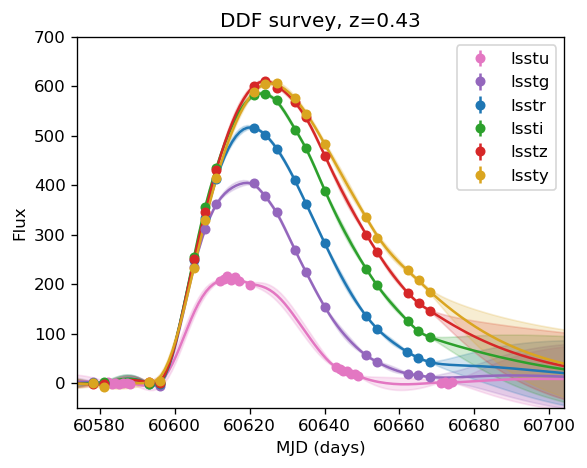

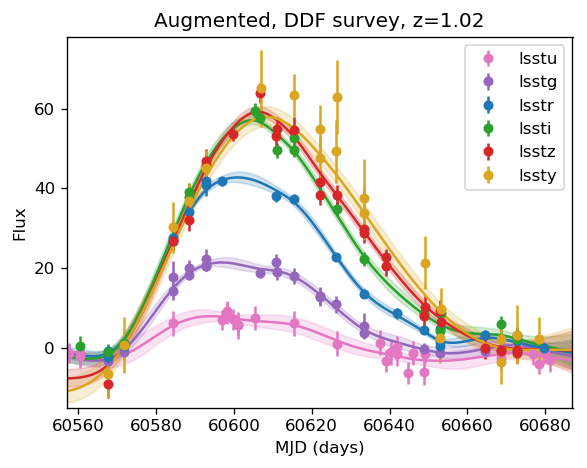

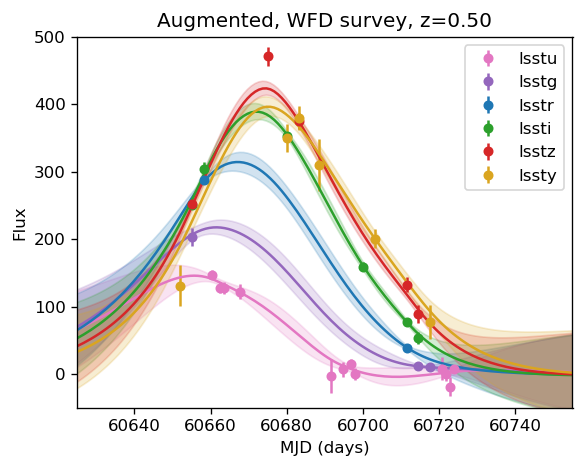

In [53]:
# Augmented fits to a superluminous supernova
# All of the plots are roughly referenced to z-band max

start_dt = 50
end_dt = 80

ref_time = 60624
plasticc_paper_plot(
    d_aug_slsn, 'plasticc_000170753',
    ref_time - start_dt, ref_time + end_dt,
    -50, 700,
    plot_name='slsn_original'
)

ref_time = 60607
plasticc_paper_plot(
    d_aug_slsn, 'plasticc_000170753_aug_hDykRmgsWH',
    ref_time - start_dt, ref_time + end_dt,
    -15, 78,
    plot_name='slsn_aug_1'
)

ref_time = 60675
plasticc_paper_plot(
    d_aug_slsn, 'plasticc_000170753_aug_iRFvQLQqyb',
    ref_time - start_dt, ref_time + end_dt,
    -50, 500,
    plot_name='slsn_aug_2'
)

# Compare how often the two classifiers agree with each other

In [54]:
classifier_1 = 'flat_weight'
classifier_2 = 'redshift_weight'

id_map = {name: i for i, name in enumerate(prediction_names)}
pred_1 = predictions[id_map[classifier_1]]
pred_2 = predictions[id_map[classifier_2]]

match = np.argmax(pred_1.values, axis=1) == np.argmax(pred_2.values, axis=1)
frac = np.sum(match) / len(match)

print("%s and %s agree %.2f%% of the time" % (classifier_1, classifier_2, frac * 100))

flat_weight and redshift_weight agree 87.23% of the time


# Redshift distributions of the different datasets

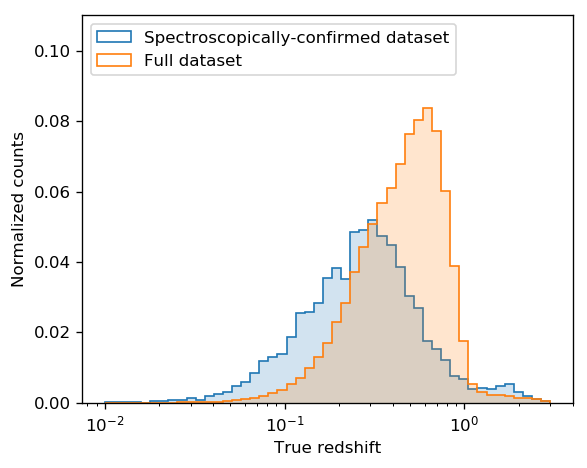

In [55]:
redshift_bins = np.logspace(np.log10(0.01), np.log10(3), 50)

def do_redshift_hist(dataset, color, label):
    # Make a histogram whose normalization integrated over log(z) is 1
    redshifts = dataset.metadata['redshift']
    weights = np.ones(len(redshifts)) / len(redshifts)
    plt.hist(redshifts, redshift_bins, histtype='step', weights=weights, color=color, label=label)
    plt.hist(redshifts, redshift_bins, histtype='stepfilled', weights=weights, color=color, alpha=0.2)

plt.figure()
do_redshift_hist(d_train, 'C0', 'Spectroscopically-confirmed dataset')
do_redshift_hist(dataset, 'C1', 'Full dataset')

plt.legend(loc=2)
plt.xscale('log')

plt.xlabel('True redshift')
plt.ylabel('Normalized counts')

plt.ylim(0, 0.11)
plt.tight_layout()

plt.savefig('./figures/redshift_distribution.pdf')

# Training set feature histograms

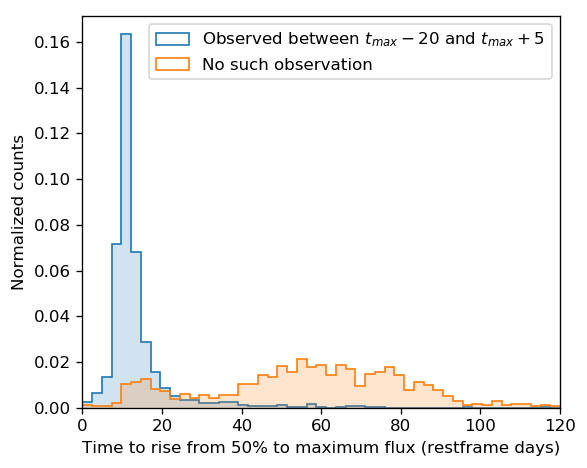

In [56]:
# Histogram of rise times vs observation counts
bins = np.linspace(0, 120, 50)

def do_cool_hist(vals, color, label):
    # Make a histogram whose normalization integrated over log(z) is 1
    plt.hist(vals, bins, histtype='step', density=True, color=color, label=label)
    plt.hist(vals, bins, histtype='stepfilled', density=True, color=color, alpha=0.2)
    
plt.figure()

# Only make this plot for SNe Ia
base_cut = d_train.metadata['class'] == 90

cut = d_train.features['count_max_rise_20'] > 2

var = d_train.features['time_bwd_max_0.5'] / (1 + d_train.metadata['redshift'])
do_cool_hist(var[base_cut & cut], 'C0', 'Observed between $t_{max} - 20$ and $t_{max} + 5$')
do_cool_hist(var[base_cut & ~cut], 'C1', 'No such observation')

plt.legend()
plt.xlabel('Time to rise from 50% to maximum flux (restframe days)')
plt.ylabel('Normalized counts')
plt.xlim(0, 120)
    
plt.tight_layout()

plt.savefig('./figures/rise_time_counts.pdf')

# Feature importance plots

In [57]:
def plot_feature_importances(classifier_name):
    classifier = avocado.load_classifier(classifier_name)
    
    importances = classifier.importances
    
    # Normalize the importances for the classifiers trained on each fold.
    importances['normed_gain'] = 0.
    for fold in np.unique(importances['fold']):
        fold_mask = importances['fold'] == fold
        norm = np.sum(importances[fold_mask]['gain']) / 1000.
        importances.loc[fold_mask, 'normed_gain'] = importances.loc[fold_mask, 'gain'] / norm
    
    stats = classifier.importances.groupby('feature')['normed_gain'].aggregate(['mean', 'max', 'min'])
    stats.sort_values('mean', inplace=True, ascending=True)
    
    stats['min_diff'] = stats['mean'] - stats['min']
    stats['max_diff'] = stats['max'] - stats['mean']
    
    count = len(stats)
    plt.figure(figsize=(8, 8))
    plt.barh(range(count), stats['mean'][:count], xerr=(stats['min_diff'][:count], stats['max_diff'][:count]), align="center", alpha=0.5)
    plt.yticks(range(count), stats.index[:count])
    plt.gca().invert_yaxis()
    plt.xlabel('Relative importance of feature for classification')
    plt.ylim(-0.7, count-0.3)
    plt.tight_layout()
    
    plt.savefig('./figures/%s_importances.pdf' % classifier_name)

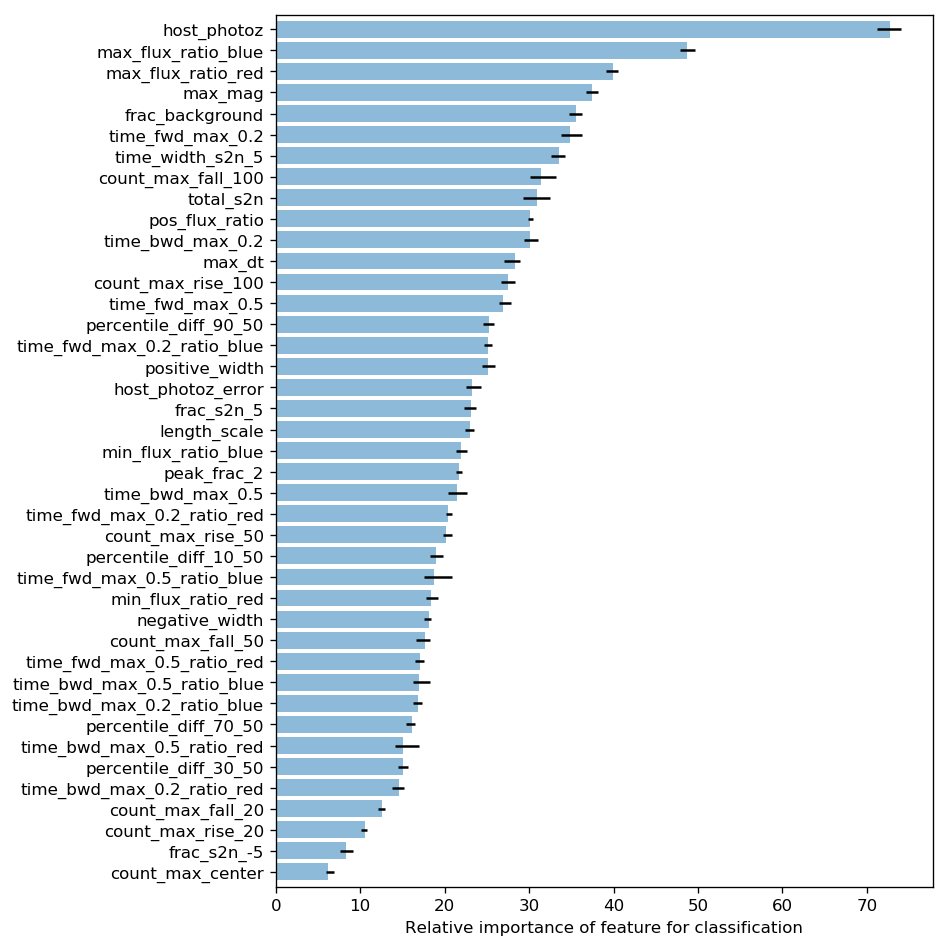

In [58]:
plot_feature_importances('flat_weight')

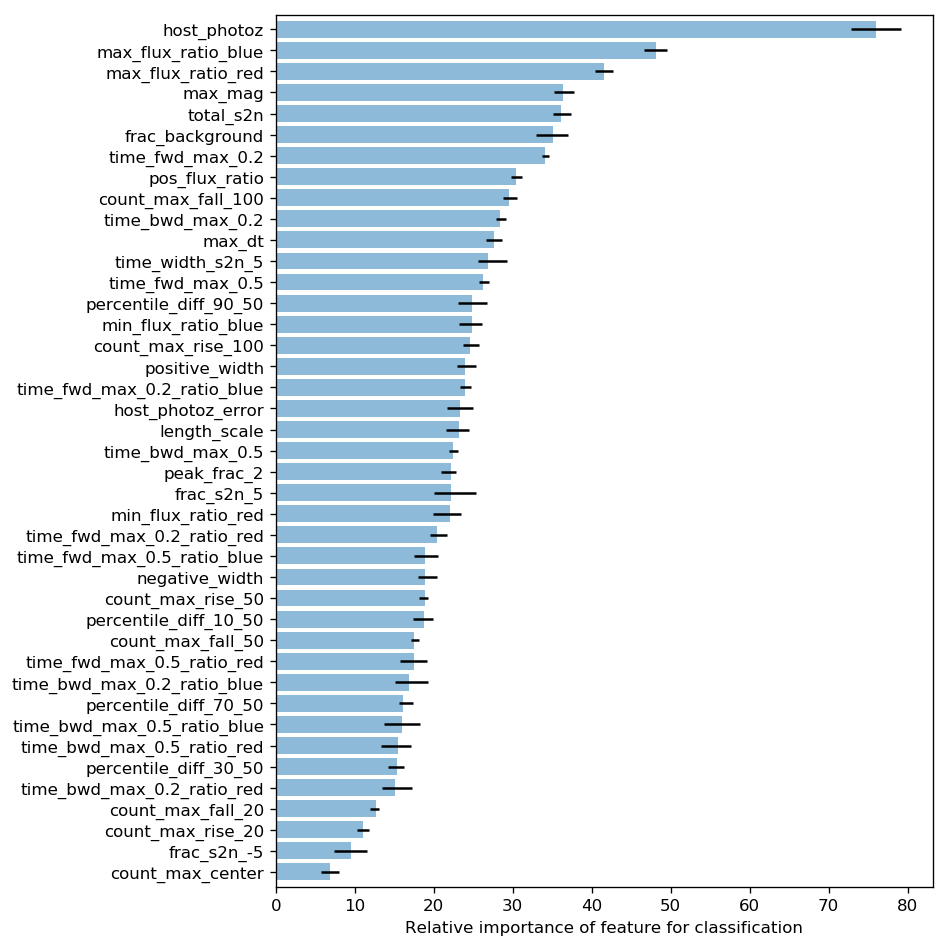

In [59]:
plot_feature_importances('redshift_weight')